This is jupyter notebook which shows the geographical locations of Greens and Labor voters, using a Voronoi diagram centred on the voring booths.  We make the assumption that everybody votes at the booth closest to their residence.  Even if if this is not absolutely true, it is a reasonable assumption for this exercise.

In [1]:
# import needed libraries and functions

import folium
import pandas as pd
from folium.plugins import BeautifyIcon
from folium.features import DivIcon
import geopandas as gpd
import shapely as sh
import numpy as np
from math import floor, ceil

import matplotlib.pyplot as plt
import matplotlib.colors as mcls

In [2]:
from geovoronoi import voronoi_regions_from_coords

In [4]:
# now import necessary files: shape files for GIS, and voting statistis.  These are all available from the AES.

vic = gpd.read_file("E_VIC21_region.shp")       # shapefiles for electorate boundaries
booths = pd.read_csv('polling_booths_2022.csv') # positions of booths
tcp = pd.read_csv('HouseTcpByCandidateByPollingPlaceDownload-27966_2.csv')  # TCP statistics

In [21]:
tcp.columns

Index(['StateAb', 'DivisionID', 'DivisionNm', 'PollingPlaceID', 'PollingPlace',
       'CandidateID', 'Surname', 'GivenNm', 'BallotPosition', 'Elected',
       'HistoricElected', 'PartyAb', 'PartyNm', 'OrdinaryVotes', 'Swing'],
      dtype='object')

In [7]:
# Isolate shape files and convert them to Json for inclusion in a folium map

wills_shp = vic.loc[vic["Elect_div"]=="Wills"]
wills_json= wills_shp.to_json()
wills_j = folium.GeoJson(data=wills_json)

cooper_shp = vic.loc[vic["Elect_div"]=="Cooper"]
cooper_json = cooper_shp.to_json()
cooper_j = folium.GeoJson(data=cooper_json)

In [9]:
display(wills_shp)
display(cooper_shp)

,E_div_numb,Elect_div,Numccds,Actual,Projected,Total_Popu,Australian,Area_SqKm,Sortname,geometry
38,39,Wills,348,108904,116877,0,0,46.44,Wills,"POLYGON Z ((144.97668 -37.77322 0.00000, 144.9..."


,E_div_numb,Elect_div,Numccds,Actual,Projected,Total_Popu,Australian,Area_SqKm,Sortname,geometry
7,8,Cooper,341,109021,115519,0,0,59.41,Cooper,"POLYGON Z ((144.99899 -37.78542 0.00000, 144.9..."


In [10]:
wills_crs = wills_shp.to_crs(epsg=4326)
wills_poly = wills_crs.at[38,"geometry"]

cooper_crs = cooper_shp.to_crs(epsg=4326)
cooper_poly = cooper_crs.at[7,"geometry"]

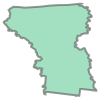

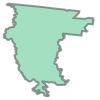

In [15]:
# quick check that we have isolated the electorates

display(wills_poly)
display(cooper_poly)

In [57]:
# Now start on the booths.  What we want is a dataframe which contains, for each electorate:
#
# Polling place name, latitute & longitude, ratio of votes cast, shapefiles of Voronoi regions
# We start with the first three

wills_booths = booths.loc[booths["DivisionNm"]=="Wills"][["PollingPlaceNm","Latitude","Longitude"]].reset_index(drop=True)

wills_tcp = tcp.loc[tcp["DivisionNm"]=="Wills"][["PollingPlace","Surname","OrdinaryVotes","Swing"]].reset_index()

# Remove rows with 0 votes

wills_tcp = wills_tcp[wills_tcp["OrdinaryVotes"] > 0]
places = wills_tcp["PollingPlace"].unique()

wills_booths = wills_booths.loc[wills_booths["PollingPlaceNm"].isin(places)]

ratios = []
for p in places:
    Labor_votes = wills_tcp.loc[(wills_tcp["Surname"]=="KHALIL") & (wills_tcp["PollingPlace"]==p),"OrdinaryVotes"].values[0]
    Green_votes = wills_tcp.loc[(wills_tcp["Surname"]=="JEFFORD") & (wills_tcp["PollingPlace"]==p),"OrdinaryVotes"].values[0]
    ratios += [Labor_votes/Green_votes]
    
wills_booths["Vote_ratio"]=ratios

In [60]:
cooper_booths = booths.loc[booths["DivisionNm"]=="Cooper"][["PollingPlaceNm","Latitude","Longitude"]].reset_index(drop=True)

cooper_tcp = tcp.loc[tcp["DivisionNm"]=="Cooper"][["PollingPlace","Surname","OrdinaryVotes","Swing"]].reset_index()

# Remove rows with 0 votes

cooper_tcp = cooper_tcp[cooper_tcp["OrdinaryVotes"] > 0]
places = cooper_tcp["PollingPlace"].unique()

cooper_booths = cooper_booths.loc[cooper_booths["PollingPlaceNm"].isin(places)]

ratios = []
for p in places:
    Labor_votes = cooper_tcp.loc[(cooper_tcp["Surname"]=="KEARNEY") & (cooper_tcp["PollingPlace"]==p),"OrdinaryVotes"].values[0]
    Green_votes = cooper_tcp.loc[(cooper_tcp["Surname"]=="LIDDLE") & (cooper_tcp["PollingPlace"]==p),"OrdinaryVotes"].values[0]
    ratios += [Labor_votes/Green_votes]
    
cooper_booths["Vote_ratio"]=ratios

In [64]:
# Now use GIS functions to isolate interior booths

wills_gpd = gpd.GeoDataFrame(
    wills_booths, geometry=gpd.points_from_xy(wills_booths.Longitude, wills_booths.Latitude))
wills_booths_crs = wills_gpd.set_crs(epsg=4326)

wills_interior_booths = wills_booths_crs[wills_booths_crs.geometry.within(wills_poly)].reset_index(drop=True)

In [67]:
cooper_gpd = gpd.GeoDataFrame(
    cooper_booths, geometry=gpd.points_from_xy(cooper_booths.Longitude, cooper_booths.Latitude))
cooper_booths_crs = cooper_gpd.set_crs(epsg=4326)

cooper_interior_booths = cooper_booths_crs[cooper_booths_crs.geometry.within(cooper_poly)].reset_index(drop=True)

In [70]:
# Now we can create the Voronoi regions

wills_interior_coords = np.array(wills_interior_booths[["Longitude","Latitude"]])
cooper_interior_coords = np.array(cooper_interior_booths[["Longitude","Latitude"]])

wills_polys, wills_pts = voronoi_regions_from_coords(wills_interior_coords, wills_poly, per_geom=False)
cooper_polys, cooper_pts = voronoi_regions_from_coords(cooper_interior_coords, cooper_poly, per_geom=False)

In [72]:
# Create index lists so that we can attach a shapefile to the correct voting booth


Nw = wills_interior_booths.shape[0]
wills_index_list = Nw*[0]
for key,val in wills_pts.items():
    wills_index_list[val[0]] = key
    
Nc = cooper_interior_booths.shape[0]
cooper_index_list = Nc*[0]
for key,val in cooper_pts.items():
    cooper_index_list[val[0]] = key

In [73]:
# Now add region geonetries to each interior booths dataframe

wills_geometries = [wills_polys[wills_index_list[k]] for k in range(Nw)]
wills_interior_booths["geometry"]=wills_geometries

cooper_geometries = [cooper_polys[cooper_index_list[k]] for k in range(Nc)]
cooper_interior_booths["geometry"]=cooper_geometries

In [95]:
# Start creating maps, first Wills

wills_bounds = wills_shp.total_bounds  # array([144.898012, -37.779319, 144.986865, -37.69094 ])
extent = 0.1
centre = [(wills_bounds[1]+wills_bounds[3])/2,(wills_bounds[0]+wills_bounds[2])/2]

wills_map = folium.Map(location=centre, min_lat=wills_bounds[1]-extent, max_lat=wills_bounds[3]+extent,
               min_long=wills_bounds[0]-extent, max_long=wills_bounds[2]+extent,
               width=750,height=1000,zoom_start=13,scrollWheelZoom=False)

In [102]:
# Same for Cooper

cooper_bounds = cooper_shp.total_bounds  # array([144.898012, -37.779319, 144.986865, -37.69094 ])
extent = 0.1
centre = [(cooper_bounds[1]+cooper_bounds[3])/2,(cooper_bounds[0]+cooper_bounds[2])/2]

cooper_map = folium.Map(location=centre, min_lat=cooper_bounds[1]-extent, max_lat=cooper_bounds[3]+extent,
               min_long=cooper_bounds[0]-extent, max_long=cooper_bounds[2]+extent,
               width=750,height=1000,zoom_start=13,scrollWheelZoom=False)

In [99]:
# Now add the Voronoi regoins to the Wills map

for index,row in wills_interior_booths.iterrows():
    rloc = [row["Longitude"],row["Latitude"]]
    rloci = [row["Latitude"],row["Longitude"]]
    row_json = gpd.GeoSeries([row["geometry"]]).to_json()
    rtext = (
        '<div style="font-size: 12pt">{s1}<br>ALP/Grn = {r1}</div>'
    ).format(s1 = row["PollingPlaceNm"],r1=row["Vote_ratio"])
    ttip1 = (
        "<b>{s1}:</b><br>"
        "ALP/Greens:\u00A0{v2}"
    ).format(s1 = row["PollingPlaceNm"],v2 = str(round(row["Vote_ratio"],3)))
    ttip2 = (
        "<b>{s1}:</b><br>"
        "Greens/ALP:\u00A0{v2}"
    ).format(s1 = row["PollingPlaceNm"],v2 = str(round(1/row["Vote_ratio"],3)))
    if row["Vote_ratio"] > 1.0:
        row_j = folium.GeoJson(data=row_json,style_function=lambda x: {'fillColor': 'red'})
        row_j.add_to(wills_map)
        folium.CircleMarker(radius=5,color="black",fill=True,location=rloci,tooltip=ttip1).add_to(wills_map)
    else:
        row_j = folium.GeoJson(data=row_json,style_function=lambda x: {'fillColor': 'green'})
        row_j.add_to(wills_map)
        folium.CircleMarker(radius=5,color="black",fill=True,location=rloci,tooltip=ttip2).add_to(wills_map)

In [97]:
wills_map

In [100]:
wills_map.save("wills_voronoi.html")

In [103]:
# Now add the Voronoi regoins to the Cooper map

for index,row in cooper_interior_booths.iterrows():
    rloc = [row["Longitude"],row["Latitude"]]
    rloci = [row["Latitude"],row["Longitude"]]
    row_json = gpd.GeoSeries([row["geometry"]]).to_json()
    rtext = (
        '<div style="font-size: 12pt">{s1}<br>ALP/Grn = {r1}</div>'
    ).format(s1 = row["PollingPlaceNm"],r1=row["Vote_ratio"])
    ttip1 = (
        "<b>{s1}:</b><br>"
        "ALP/Greens:\u00A0{v2}"
    ).format(s1 = row["PollingPlaceNm"],v2 = str(round(row["Vote_ratio"],3)))
    ttip2 = (
        "<b>{s1}:</b><br>"
        "Greens/ALP:\u00A0{v2}"
    ).format(s1 = row["PollingPlaceNm"],v2 = str(round(1/row["Vote_ratio"],3)))
    if row["Vote_ratio"] > 1.0:
        row_j = folium.GeoJson(data=row_json,style_function=lambda x: {'fillColor': 'red'})
        row_j.add_to(cooper_map)
        folium.CircleMarker(radius=5,color="black",fill=True,location=rloci,tooltip=ttip1).add_to(cooper_map)
    else:
        row_j = folium.GeoJson(data=row_json,style_function=lambda x: {'fillColor': 'green'})
        row_j.add_to(cooper_map)
        folium.CircleMarker(radius=5,color="black",fill=True,location=rloci,tooltip=ttip2).add_to(cooper_map)

In [104]:
cooper_map

In [105]:
cooper_map.save("cooper_voronoi.html")

In [91]:
for index,row in wills_tcp.iterrows():
    print(row["PollingPlace"],row["Surname"],row["OrdinaryVotes"])
    

Brunswick KHALIL 891
Brunswick JEFFORD 1212
Brunswick East (Wills) KHALIL 409
Brunswick East (Wills) JEFFORD 586
Brunswick North KHALIL 1290
Brunswick North JEFFORD 1449
Brunswick North East KHALIL 864
Brunswick North East JEFFORD 1177
Brunswick North West KHALIL 504
Brunswick North West JEFFORD 543
Brunswick South KHALIL 579
Brunswick South JEFFORD 654
Brunswick South East (Wills) KHALIL 331
Brunswick South East (Wills) JEFFORD 613
Brunswick South West KHALIL 846
Brunswick South West JEFFORD 864
Brunswick West KHALIL 659
Brunswick West JEFFORD 601
Coburg KHALIL 800
Coburg JEFFORD 772
Coburg East KHALIL 564
Coburg East JEFFORD 418
Coburg Lake (Wills) KHALIL 239
Coburg Lake (Wills) JEFFORD 231
Coburg North KHALIL 478
Coburg North JEFFORD 330
Coburg North West KHALIL 1025
Coburg North West JEFFORD 762
Coburg South KHALIL 455
Coburg South JEFFORD 437
Coburg West KHALIL 1429
Coburg West JEFFORD 879
Essendon WILLS PPVC KHALIL 496
Essendon WILLS PPVC JEFFORD 236
Fawkner KHALIL 822
Fawkner JE

In [92]:
wills_interior_booths

,PollingPlaceNm,Latitude,Longitude,Vote_ratio,geometry
0,Brunswick,-37.771500,144.960000,0.735149,"POLYGON Z ((144.95402 -37.76685 0.00000, 144.9..."
1,Brunswick East (Wills),-37.772788,144.980243,0.697952,"POLYGON Z ((144.97028 -37.76972 0.00000, 144.9..."
2,Brunswick North,-37.759900,144.951000,0.890269,"POLYGON ((144.95962 -37.76028, 144.95725 -37.7..."
3,Brunswick North East,-37.765203,144.979674,0.734070,"POLYGON Z ((144.96984 -37.76836 0.00000, 144.9..."
4,Brunswick North West,-37.756987,144.944426,0.928177,"POLYGON Z ((144.94140 -37.75046 0.00000, 144.9..."
5,Brunswick South,-37.774301,144.952633,0.885321,"POLYGON Z ((144.95016 -37.76729 0.00000, 144.9..."
6,Brunswick South West,-37.770634,144.943514,0.979167,"POLYGON Z ((144.94863 -37.76623 0.00000, 144.9..."
7,Brunswick West,-37.762086,144.943297,1.096506,"POLYGON Z ((144.93798 -37.76650 0.00000, 144.9..."
8,Coburg,-37.741019,144.966009,1.036269,"POLYGON Z ((144.95919 -37.73770 0.00000, 144.9..."
9,Coburg East,-37.746751,144.978274,1.349282,"POLYGON Z ((144.97462 -37.75380 0.00000, 144.9..."


In [94]:
folium.Map?